# Mood-RL Centered Regression

## Section 1: Motivating the model

## Section 2: Model fitting

In [1]:
import os, pystan
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import _pickle as cPickle
from pandas import DataFrame, read_csv
from scripts.diagnostics import check_div, check_energy, check_treedepth
from scripts.plotting import plot_subject
sns.set_style('white')
sns.set_context('notebook', font_scale=1.75)
%matplotlib inline
%load_ext jupyternotify

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Select model.
model_name = False

## Sampling parameters.
samples = 1250
warmup = 1000
chains = 4
thin = 1
n_jobs = 4

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load and prepare behavior data.
data = read_csv('data/moodRL_data.csv')
data = data[data.Block < 4]
data = data.fillna(-1)

## Load and prepare ratings data.
ratings = read_csv('data/moodRL_ratings.csv')
ratings = ratings[ratings.Variable=='Mood']

## Load and prepare metadata.
metadata = read_csv('data/moodRL_metadata.csv')

## Define metadata.
N = data.Datetime.unique().size
B = data.Block.max()
T = data.Trial.max()

## Extract and prepare stimulus presentation data.
X = data[['M1','M2']].values.reshape(N,B,T,2)

## Extract and prepare choice data. 
## Missing values coded as -1.
Y = data.Choice.values.reshape(N,B,T,1)
Y = np.where( np.any(np.equal(X, Y), axis=-1), np.argmax(np.equal(X, Y), axis=-1) + 1, -1 )

## Extract and prepare reward data. All rewards 
## scaled between [0,1].
R = data.Outcome.values.reshape(N,B,T)
R = np.where(R > 0, 1, 0)

## Extract and prepare mood data.
M = ratings.loc[ratings.Trial>0, 'Rating'].values.reshape(N,B,3) / 4

m2 = ratings.loc[np.logical_and(ratings.Block==2, ratings.Trial==0),'Rating'].values / 4
m2 = np.where(m2==-1, -0.99, np.where(m2==1, 0.99, m2))

## Organize data dictionary.
dd = dict(N=N, B=B, T=T, X=X, Y=Y, R=R, M=M, m2=m2)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Fit model with Stan.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

if model_name:

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Model fitting and diagnostics.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
    ## Fit model.
    file = 'stan_models/%s' %model_name
    fit = pystan.stan(file=file, data=dd, iter=samples, warmup=warmup, thin=thin, chains=chains, 
                      control=dict(adapt_delta = 0.9), n_jobs=n_jobs, seed=47404)
    check_div(fit); check_treedepth(fit); check_energy(fit)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Save data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Create out-directory.
    out_dir = 'stan_fits/%s' %model_name.replace('.stan','')
    if not os.path.isdir(out_dir): os.makedirs(out_dir)

    ## Save summary file.
    summary = fit.summary()
    summary = DataFrame(summary['summary'], columns=summary['summary_colnames'], index=summary['summary_rownames'])
    summary.to_csv(os.path.join(out_dir, 'summary.csv'))

    ## Save contents of StanFit.
    extract = fit.extract()
    for k, v in dd.items(): extract[k] = v
    with open(os.path.join(out_dir, 'StanFit.pickle'), 'wb') as fn: cPickle.dump(extract, fn)
        
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Plot subjects.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Make plots dir.
    plots_dir = os.path.join(out_dir, 'plots')
    if not os.path.isdir(plots_dir): os.makedirs(plots_dir)

    ## Iteratively plot.
    for i in np.arange(extract['N']):

        ## Plot and save.
        fig, axes = plot_subject(extract, i)
        fig.savefig(os.path.join(plots_dir, 'subj_%s.png' %(i+1)), dpi=180)
        plt.close('all')
        
    print('Done.')

<IPython.core.display.Javascript object>

## Section 3: Model comparisons

### Posterior predictive checks

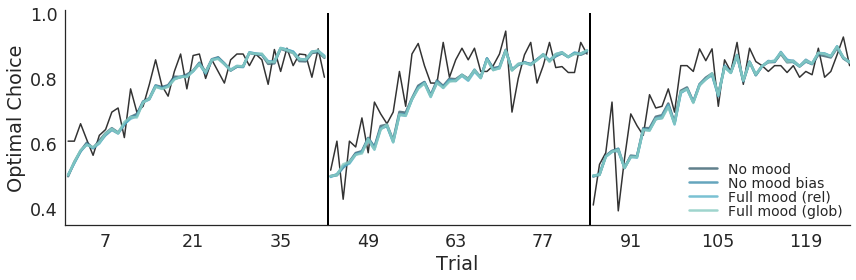

In [2]:
from scripts.plotting import plot_group_behavior

## Define parameters.
models = ['moodRL_centered_no_mood', 'moodRL_centered_no_mood_bias',
          'moodRL_centered_full_mood_rel', 'moodRL_centered_full_mood_glob']
labels = ['No mood', 'No mood bias', 'Full mood (rel)', 'Full mood (glob)']
colors = sns.color_palette('GnBu_d', n_colors=4)

## Plot models.
fig, ax = plt.subplots(1,1,figsize=(12,4))
for model, observed, color, label in zip(models, [1,0,0,0], colors, labels):
    plot_group_behavior(model, observed=observed, color=color, label=label, ax=ax)
ax.legend(loc=4, borderpad=0, fontsize=14, labelspacing=0)

sns.despine()
plt.tight_layout()

### Model comparisons with WAIC

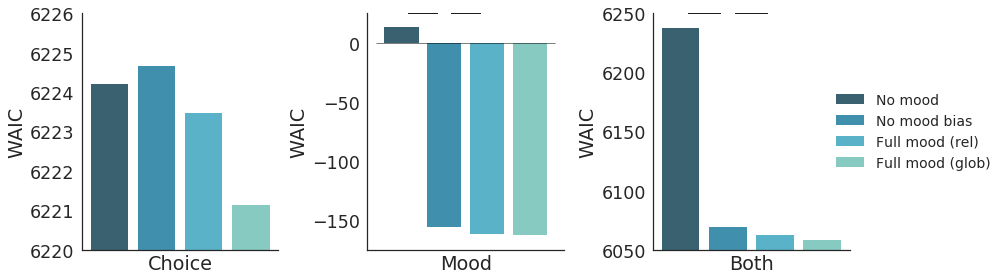

In [3]:
from scripts.utilities import model_comparison

fig, axes = plt.subplots(1,3,figsize=(12,4))
xlabels = ['Choice', 'Mood', 'Both']
ylimits = np.array([(6220,6226), (-175,25), (6.05e3,6.25e3)])

for ax, var, xlabel, ylim in zip(axes, ['y','m','both'], xlabels, ylimits):
    
    for i in np.arange(1,len(models)):
        
        ## Perform model comparison.
        w1, w2, se = model_comparison(models[i-1], models[i], on=var, verbose=False)
        
        ## Plot.
        ax.bar([i-1,i],[w1,w2],color=colors[i-1:i+1])
        
        ## Add difference.
        if np.abs(w1 - w2) > se: ax.hlines(ylim[1], i-0.85, i-0.15 )
        
    if np.logical_xor(*ylim>0): ax.hlines(0,*ax.get_xlim(),lw=0.5)
    ax.set(xticks=[], xlabel=xlabel, ylim=ylim, ylabel='WAIC')
    
## Add legend.
for color, label in zip(colors, labels): ax.bar(0,0,color=color,label=label)
ax.legend(loc=7, bbox_to_anchor=(1.75,0.5), fontsize=14, borderpad=0)
    
sns.despine()
plt.tight_layout()

### Correlations with mood

No mood bias: t=6.68, p=0.000
Full mood (rel): t=6.63, p=0.000
Full mood (glob): t=6.58, p=0.000


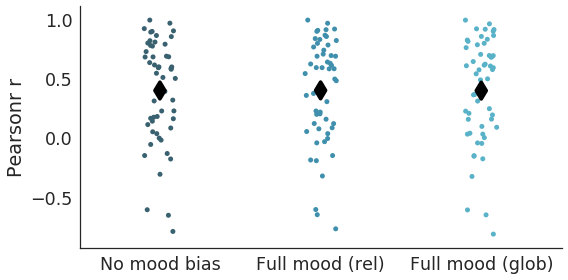

In [4]:
from scipy.stats import pearsonr, ttest_1samp
from scripts.utilities import load_fit

df = []
for model, label in zip(models[1:], labels[1:]):
    
    ## Load StanFit.
    fit = load_fit(model)
    
    ## Prepare mood data.
    M = fit['M']
    h_pred = ( np.median(fit['h_pred'], axis=0).T + np.median(fit['beta_h'], axis=0) ).T
    Mhat = np.tanh(h_pred[...,[7,21,35]])
    
    ## Compute correlations.
    rvals = np.array([pearsonr(x.flatten(),y.flatten())[0] for x,y in zip(M,Mhat)])
    rvals = rvals[~np.isnan(rvals)]
    df.append(rvals)
    
    ## Perform t-test.
    t, p = ttest_1samp(rvals, 0)
    print('%s: t=%0.2f, p=%0.3f' %(label,t,p))

## Convert to DataFrame.
df = DataFrame(np.array(df).T, columns=labels[1:]).melt(var_name='Model', value_name='R')

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))
sns.stripplot('Model', 'R', data=df, palette=colors, jitter=True, zorder=0, ax=ax)
sns.pointplot('Model', 'R', data=df, join=False, color='k', 
              ci=None, markers='d', scale=1.5, ax=ax)
ax.set(xlabel='', ylabel='Pearsonr r')

sns.despine()
plt.tight_layout()

### Mood bias and HPS

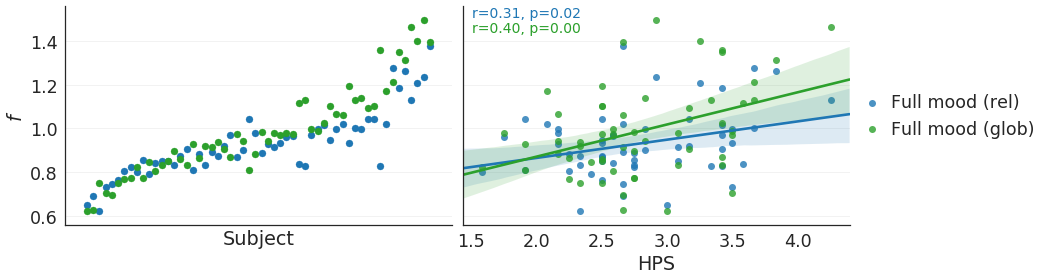

In [5]:
## Load f values.
f = np.array([np.median(load_fit(model)['f'], axis=0) for model in models[-2:]])

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(12,4),sharey=True)
colors = ['#1f77b4','#2ca02c']

## Plot f point estimates.
sort_ix = np.argsort(f.mean(axis=0))
for arr, color in zip(f,colors): 
    axes[0].scatter(np.arange(arr.size), arr[sort_ix], color=color)
axes[0].set(xticks=[], xlabel='Subject', ylabel=r'$f$')
axes[0].grid(axis='y', alpha=0.25)

## Plot HPS regression.
for i, arr, color, label in zip(range(2),f,colors,labels[-2:]):
    sns.regplot(metadata.IPIP_hps, arr, color=color, label=label, ax=axes[1])
    axes[1].annotate('r=%0.2f, p=%0.2f' %pearsonr(metadata.IPIP_hps, arr), xy=(0,0),
                     xytext=(0.025,0.95-0.07*i), xycoords=('axes fraction'), 
                     fontsize=14, color=color)
    
axes[1].set(xlabel='HPS')
axes[1].grid(axis='y', alpha=0.25)
axes[1].legend(loc=7, bbox_to_anchor=(1.5,0.5), borderpad=0, handletextpad=0.1)
    
sns.despine()
plt.tight_layout()

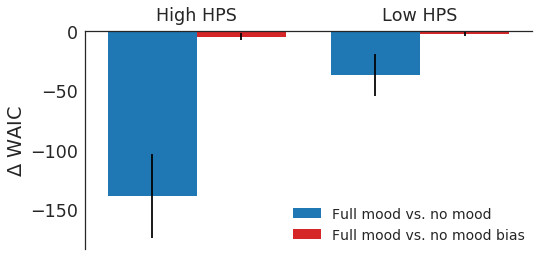

In [6]:
from scripts.utilities import _extract_log_lik, WAIC

## Define models.
models = ['moodRL_centered_no_mood', 'moodRL_centered_no_mood_bias', 
          'moodRL_centered_full_mood_glob']

## Iteratively compute WAIC.
waic = []
for model in models:
    _, Mll = _extract_log_lik(model, 'm')
    waic.append( -2 * WAIC(Mll) )    
waic = np.array(waic)
    
## Define index of high HPS vs. low HPS.
low_hps = np.repeat(metadata.IPIP_hps, 9) < np.median(metadata.IPIP_hps)

## Initialze canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))

## Iteratively compute and plot difference.
for i in np.arange(2):
    
    ## Compute WAIC scores.
    ix = low_hps == i
    m1, m2, m3 = waic[:,ix].sum(axis=-1)
    
    ## Compute standard errors.
    se_13 = np.sqrt((ix==i).sum() * np.var(waic[0,ix] - waic[2,ix]))
    se_23 = np.sqrt((ix==i).sum() * np.var(waic[1,ix] - waic[2,ix]))
    
    ax.bar(2.5*i, m3-m1, 1, yerr=se_13, color='#1f77b4', label='Full mood vs. no mood'*i)
    ax.bar(2.5*i+1, m3-m2, 1,yerr=se_23, color='#d62728', label='Full mood vs. no mood bias'*i)
    
ax.hlines(0, -0.75, 4.25, lw=0.5)
ax.set(xlim=(-0.75, 4.25), xticks=[0.5,3], xticklabels=['High HPS','Low HPS'], ylabel=r'$\Delta$ WAIC')
ax.legend(loc=4, borderpad=0, fontsize=14)
sns.despine(top=False, bottom=True)

## Section 4: Investigating model predictiveness 

### Point estimates of parameters

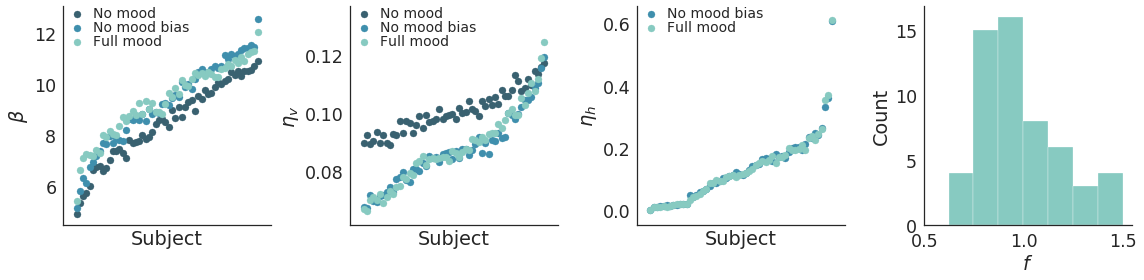

In [7]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

models = ['moodRL_centered_no_mood', 'moodRL_centered_no_mood_bias',
          'moodRL_centered_full_mood_glob']
labels =  ['No mood', 'No mood bias','Full mood']
colors = ['#396170', '#3f8fad', '#87cac1']

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,4,figsize=(16,4))

## Plot beta.
beta = [np.median(load_fit(model)['beta'], axis=0) for model in models]
sort_ix = np.argsort(np.mean(beta, axis=0))
for arr, color, label in zip(beta,colors, labels): 
    axes[0].scatter(np.arange(arr.size), arr[sort_ix], color=color, label=label)
axes[0].set(xticks=[], xlabel='Subject', ylabel=r'$\beta$')
axes[0].legend(loc=2, borderpad=-0.5, labelspacing=0, handletextpad=0.1, fontsize=14)
    
## Plot eta_v.
eta_v = [np.median(load_fit(model)['eta_v'], axis=0) for model in models]
sort_ix = np.argsort(np.mean(eta_v, axis=0))
for arr, color, label in zip(eta_v,colors,labels): 
    axes[1].scatter(np.arange(arr.size), arr[sort_ix], color=color, label=label)
axes[1].set(xticks=[], xlabel='Subject', ylabel=r'$\eta_v$')
axes[1].legend(loc=2, borderpad=-0.5, labelspacing=0, handletextpad=0.1, fontsize=14)
    
## Plot eta_h.
eta_h = [np.median(load_fit(model)['eta_h'], axis=0) for model in models[1:]]
sort_ix = np.argsort(np.mean(eta_h, axis=0))
for arr, color, label in zip(eta_h,colors[1:],labels[1:]): 
    axes[2].scatter(np.arange(arr.size), arr[sort_ix], color=color, label=label)
axes[2].set(xticks=[], xlabel='Subject', ylabel=r'$\eta_h$')
axes[2].legend(loc=2, borderpad=-0.5, labelspacing=0, handletextpad=0.1, fontsize=14)

## Plot f.
sns.distplot(np.median(load_fit(models[-1])['f'], axis=0), kde=False, color=colors[-1], 
             hist_kws=dict(alpha=1, edgecolor='w'), ax=axes[-1])
axes[3].set(xticks=np.arange(0.5,1.6,0.5), xlabel=r'$f$', ylabel='Count')

sns.despine()
plt.tight_layout()

### Mood as momentum

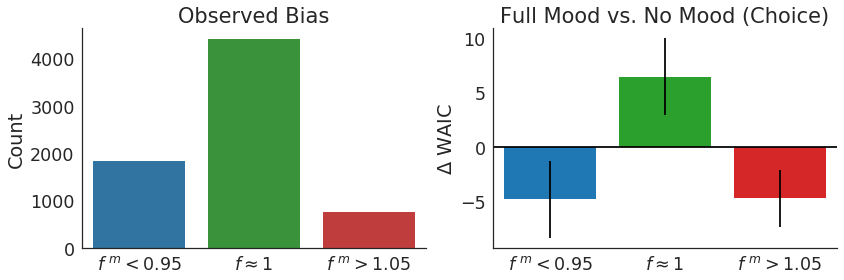

In [8]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

models = ['moodRL_centered_no_mood','moodRL_centered_full_mood_glob']

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Perform model comparison.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute the difference in WAIC between the models.
dWAIC = np.diff([ -2 * WAIC(_extract_log_lik(model,'y')[0]) for model in models ], axis=0).squeeze()

## Load StanFit.
fit = load_fit(models[-1])

## Compute mood.
h_pred = (np.median(fit['h_pred'], axis=0).T + np.median(fit['beta_h'], axis=0).T).T
Mhat = np.tanh(h_pred).flatten()
Mhat = Mhat[data.Choice>0]

## Compute bias.
f = np.median(fit['f'], axis=0)
f = f[data.loc[data.Choice>0,'Subject']-1]
bias = np.power(f, Mhat)

## Bin bias. 
bins = np.digitize(bias, [0.95, 1.05])

## Compute means and SEs.
mu_d = [dWAIC[bins==b].sum() for b in np.unique(bins)]
se = [np.sqrt( (bins==b).sum() * np.var(dWAIC[bins==b]) ) for b in np.unique(bins)]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialze canvas.
fig, axes = plt.subplots(1,2,figsize=(12,4))

## Plot counts.
sns.countplot(bins, palette=['#1f77b4','#2ca02c', '#d62728'], ax=axes[0])
axes[0].set(ylabel = r'Count',xticklabels=[r'$f^{\ m} < 0.95$', r'$f \approx 1$', r'$f^{\ m} > 1.05$'],
            title='Observed Bias')

## Plot WAIC.
axes[1].bar(np.arange(3), mu_d, yerr=se, color=['#1f77b4','#2ca02c', '#d62728'])
axes[1].hlines(0, -0.5, 2.5)
axes[1].set(xlim=(-0.5,2.5), xticks=[0,1,2], ylabel = r'$\Delta$ WAIC',
       xticklabels=[r'$f^{\ m} < 0.95$', r'$f \approx 1$', r'$f^{\ m} > 1.05$'],
       title='Full Mood vs. No Mood (Choice)')
sns.despine()
plt.tight_layout()

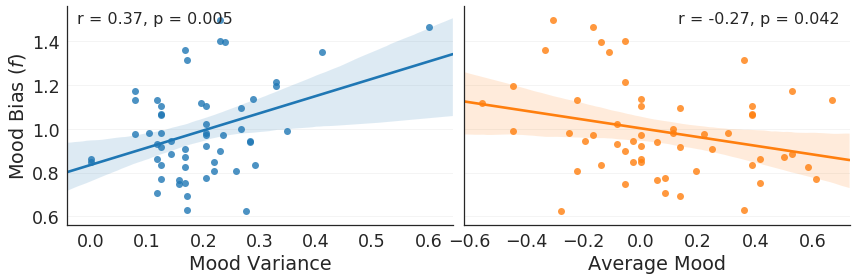

In [9]:
## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(12,4),sharey=True)

## Prepare data.
M = M.reshape(fit['N'], fit['B'] * 3)
f = np.median(fit['f'], axis=0)

## Plot.
sns.regplot(M.std(axis=1), f, ax=axes[0])
axes[0].grid(axis='y', alpha=0.2, zorder=0)
axes[0].set(xlabel='Mood Variance', ylabel=r'Mood Bias ($f$)')
axes[0].annotate('r = %0.2f, p = %0.3f' %(pearsonr(M.std(axis=1), f)), xy=(0,0), 
                 xytext=(0.025, 0.925), xycoords='axes fraction', ha='left', fontsize=16)

sns.regplot(M.mean(axis=1), f, ax=axes[1])
axes[1].grid(axis='y', alpha=0.2, zorder=0)
axes[1].set(xlabel='Average Mood')
axes[1].annotate('r = %0.2f, p = %0.3f' %(pearsonr(M.mean(axis=1), f)), xy=(0,0), 
                 xytext=(0.975, 0.925), xycoords='axes fraction', ha='right', fontsize=16)

sns.despine()
plt.tight_layout()

### Bias, learning, and RPEs

In [10]:
## Define models.
models = ['moodRL_centered_no_mood', 'moodRL_centered_full_mood_glob']

## Preallocate space.
RPE = np.zeros((len(models), fit['N'], fit['B'], fit['T']))

## Define useful local function.
extract = lambda fit, param: np.median(fit.get(param, np.ones((1, fit['N']))), axis=0)

## Main loop.
for ix, model in enumerate(models):
    
    ## Load model.
    fit = load_fit(model)
    
    for i in np.arange(fit['N']):
        
        ## Extract subject task.
        x, y, r = [fit[param][i] for param in ['X','Y','R']]
        x -= 1
        y -= 1
        
        ## Extract subject parameters.
        eta_v = np.median(fit['eta_v'], axis=0)[i]
        eta_h = np.median(fit.get('eta_h', np.zeros((1,fit['N']))), axis=0)[i]
        f = np.median(fit.get('f', np.ones((1,fit['N']))), axis=0)[i]
        beta_h = np.median(fit['beta_h'], axis=0)[i]
        m2 = fit['m2']
        
        ## Initialize values.
        Q = np.zeros(9)
        h = 0
        m = np.tanh(beta_h)
        
        for j in np.arange(fit['B']):
            
            ## If second block, update reward history/mood 
            ## to reflect Wheel of Fortune.
            if j == 1:
                m = m2[i]
                h = np.arctanh(m)
            
            for k in np.arange(fit['T']):
                                
                ## Compute reward prediction error.
                delta = (f ** m) * r[j,k] - Q[x[j,k,y[j,k]]]
                
                ## Update expectations.
                Q[x[j,k,y[j,k]]] += eta_v * delta
                
                ## Update history of rewards.
                h += eta_h * (delta - h)
                
                ## Update mood.
                m = np.tanh( beta_h + h )
                
                ## Store RPE.
                RPE[ix,i,j,k] += delta

Text(0.5,0.98,'f = 1.131, m = 0.667')

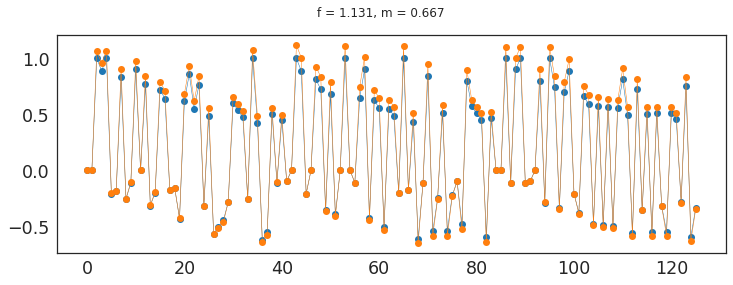

In [11]:
fig, ax = plt.subplots(1,1,figsize=(12,4))

i = 28
f = np.median(fit['f'], axis=0)[i]
m = fit['M'].reshape(fit['N'], 9).mean(axis=-1)[i]

ax.plot(np.arange(126), RPE[0,i].flatten(), marker='o', lw=0.5)
ax.plot(np.arange(126), RPE[1,i].flatten(), marker='o', lw=0.5)
fig.suptitle('f = %0.3f, m = %0.3f' %(f,m))

Text(0.5,0.98,'f = 1.118, m = -0.556')

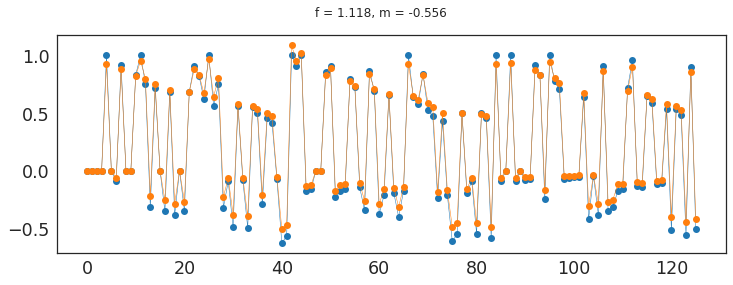

In [12]:
fig, ax = plt.subplots(1,1,figsize=(12,4))

i = 0
f = np.median(fit['f'], axis=0)[i]
m = fit['M'].reshape(fit['N'], 9).mean(axis=-1)[i]

ax.plot(np.arange(126), RPE[0,i].flatten(), marker='o', lw=0.5)
ax.plot(np.arange(126), RPE[1,i].flatten(), marker='o', lw=0.5)
fig.suptitle('f = %0.3f, m = %0.3f' %(f,m))

Text(0.5,0.98,'f = 0.864, $M_\\sigma$ = 0.000')

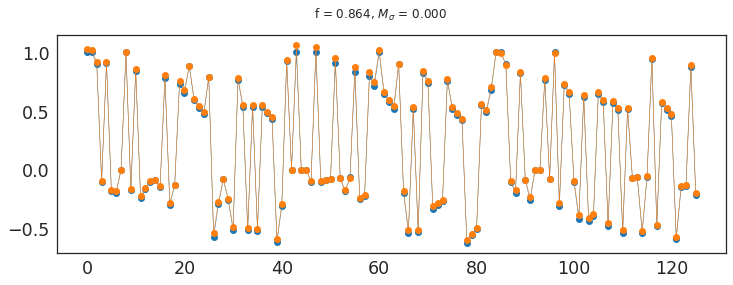

In [13]:
fig, ax = plt.subplots(1,1,figsize=(12,4))

i = 1
f = np.median(fit['f'], axis=0)[i]
m = fit['M'].reshape(fit['N'], 9).std(axis=-1)[i]

ax.plot(np.arange(126), RPE[0,i].flatten(), marker='o', lw=0.5)
ax.plot(np.arange(126), RPE[1,i].flatten(), marker='o', lw=0.5)
fig.suptitle('f = %0.3f, $M_\sigma$ = %0.3f' %(f,m))

Text(0.5,0.98,'f = 1.464, $M_\\sigma$ = 0.601')

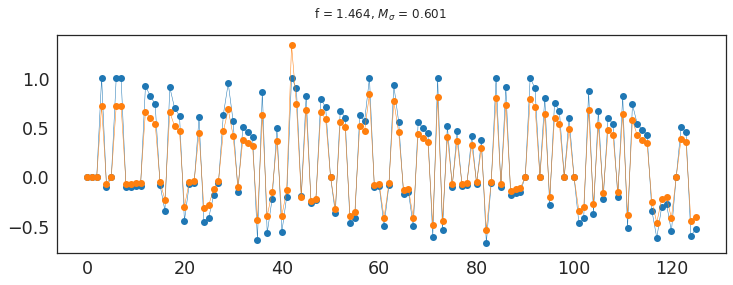

In [14]:
fig, ax = plt.subplots(1,1,figsize=(12,4))

i = 2
f = np.median(fit['f'], axis=0)[i]
m = fit['M'].reshape(fit['N'], 9).std(axis=-1)[i]

ax.plot(np.arange(126), RPE[0,i].flatten(), marker='o', lw=0.5)
ax.plot(np.arange(126), RPE[1,i].flatten(), marker='o', lw=0.5)
fig.suptitle('f = %0.3f, $M_\sigma$ = %0.3f' %(f,m))

### Confidence in bias parameter

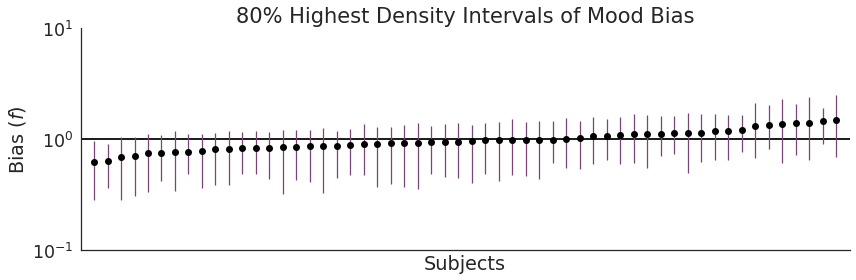

In [15]:
from scripts.utilities import HDIofMCMC

## Load StanFit.
fit = load_fit('moodRL_centered_full_mood_glob')

## Extract f.
f = fit['f']
f = f[:, np.argsort(np.median(f, axis=0))]

## Compute intervals.
mu = np.median(f, axis=0)
lb, ub = np.apply_along_axis(HDIofMCMC, 0, f, 0.8)
yerr = [mu - lb, ub-mu]

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))

## Plot.
ax.errorbar(np.arange(mu.size), np.median(f, axis=0), yerr=yerr,
            fmt='o', lw=1.25, color='k', ecolor='#774576', capsize=10)
ax.set_yscale('log')
ax.hlines(1,-1,f.shape[-1],zorder=0)
ax.set(xticks=[], xlim=(-1,f.shape[-1]), xlabel='Subjects', yticks=[0.1, 1, 10], ylabel=r'Bias ($f$)',
       title='80% Highest Density Intervals of Mood Bias')

sns.despine()
plt.tight_layout()

## Section 5: Parameter Recovery

### Simulate data

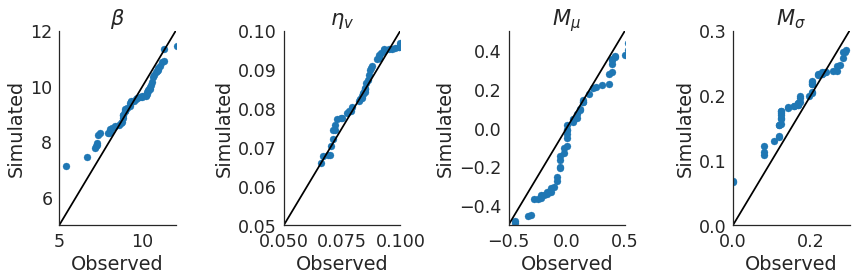

In [16]:
from scripts.simulations import MoodyAgent, slot_machine_game

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Simulation parameters.
Ns = 56    # subjects
B = 3      # blocks
T = 42     # trials

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Simulate data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Simulate mood.
mu = np.random.uniform(-2,2,Ns)
Ms = np.random.multivariate_normal(mu, np.identity(Ns)*0.7, B*3+1).T / 4
Ms = np.where(Ms < -1, -0.99, np.where(Ms > 1, 0.99, Ms))
m2s = Ms[:,-1]
Ms = Ms[:,:-1]

## Simulate agent parameters.
mu = [9.5, 0.09]
cov = [[1, 3e-3],
       [3e-3, 1e-4]]
beta, eta_v = np.random.multivariate_normal(mu, cov, Ns).T

## Preallocate space.
Xs = np.zeros([Ns,B,T,2], dtype=int)
Ys = np.zeros([Ns,B,T], dtype=int)
Rs = np.zeros([Ns,B,T], dtype=int)

## Simulate behavior.
for i in np.arange(Ns):
    
    ## Initialize agent.
    agent = MoodyAgent(beta=beta[i], eta_v=eta_v[i], eta_h=0, f=1)
    
    for j in np.arange(B):
        
        ## Simulate block of trials.
        x, r = slot_machine_game(n_trials=T, probabilities=(0.2,0.4,0.6), reward=1)
        
        ## Simulate behavior.
        y, _ = agent.simulate(x,r)
        
        ## Store.
        Xs[i,j] = x.copy() + j * B
        Ys[i,j] = y.copy()
        Rs[i,j] = [r[a,b] for a,b in enumerate(y)]

## Make arrays 1-indexed.
Xs += 1
Ys += 1
     
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,4,figsize=(12,4))

## Compare beta.
axes[0].scatter(np.sort(np.median(fit['beta'],axis=0)), np.sort(beta))
axes[0].plot([5,12],[5,12], color='k')
axes[0].set(xlim=(5,12),ylim=(5,12),xlabel='Observed',
            ylabel='Simulated', title=r'$\beta$')

## Compare eta_v.
axes[1].scatter(np.sort(np.median(fit['eta_v'],axis=0)), np.sort(eta_v))
axes[1].plot([0.05,0.10],[0.05,0.10], color='k')
axes[1].set(xlim=(0.05,0.10),ylim=(0.05,0.10),xlabel='Observed',
            ylabel='Simulated', title=r'$\eta_v$')

## Compare mood mean.
axes[2].scatter(np.sort(M.mean(axis=1)), np.sort(Ms.mean(axis=1)))
axes[2].plot([-0.5,0.5],[-0.5,0.5], color='k')
axes[2].set(xlim=(-0.5,0.5),ylim=(-0.5,0.5),xlabel='Observed',
            ylabel='Simulated', title='$M_\mu$')

## Compare mood std.
axes[3].scatter(np.sort(M.std(axis=1)), np.sort(Ms.std(axis=1)))
axes[3].plot([0.0,0.3],[0.0,0.3], color='k')
axes[3].set(xlim=(0.0,0.3),ylim=(0.0,0.3),xlabel='Observed',
            ylabel='Simulated',title='$M_\sigma$')

sns.despine()
plt.tight_layout()

### Model fitting

In [17]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Select model.
model_name = False

## Sampling parameters.
samples = 1250
warmup = 1000
chains = 4
thin = 1
n_jobs = 4

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Fit model with Stan.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Organize data dictionary.

dd = dict(N=Ns, B=B, T=T, X=Xs, Y=Ys, R=Rs, M=Ms.reshape(Ns, B, 3), m2=m2s)

if model_name:

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Model fitting and diagnostics.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
    ## Fit model.
    file = 'stan_models/%s' %model_name
    fit = pystan.stan(file=file, data=dd, iter=samples, warmup=warmup, thin=thin, chains=chains, 
                      control=dict(adapt_delta = 0.9), n_jobs=n_jobs, seed=47404)
    check_div(fit); check_treedepth(fit); check_energy(fit)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Save data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Create out-directory.
    out_dir = 'stan_fits/%s_recovery' %model_name.replace('.stan','')
    if not os.path.isdir(out_dir): os.makedirs(out_dir)

    ## Save summary file.
    summary = fit.summary()
    summary = DataFrame(summary['summary'], columns=summary['summary_colnames'], index=summary['summary_rownames'])
    summary.to_csv(os.path.join(out_dir, 'summary.csv'))

    ## Save contents of StanFit.
    extract = fit.extract()
    for k, v in dd.items(): extract[k] = v
    with open(os.path.join(out_dir, 'StanFit.pickle'), 'wb') as fn: cPickle.dump(extract, fn)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Plot subjects.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Make plots dir.
    plots_dir = os.path.join(out_dir, 'plots')
    if not os.path.isdir(plots_dir): os.makedirs(plots_dir)

    ## Iteratively plot.
    for i in np.arange(extract['N']):

        ## Plot and save.
        fig, axes = plot_subject(extract, i)
        fig.savefig(os.path.join(plots_dir, 'subj_%s.png' %(i+1)), dpi=180)
        plt.close('all')

print('Done.')

Done.


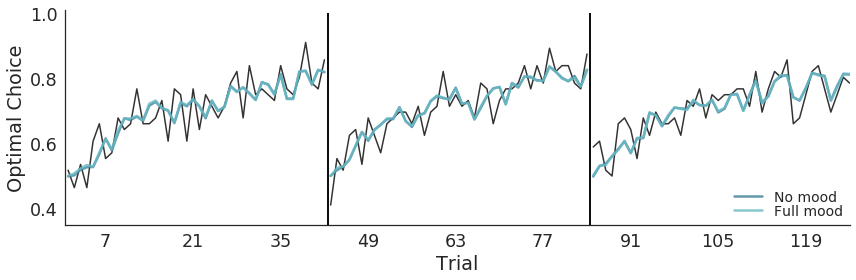

In [18]:
## Define parameters.
models = ['moodRL_centered_no_mood_recovery', 'moodRL_centered_full_mood_glob_recovery']
labels = ['No mood', 'Full mood']
colors = sns.color_palette('GnBu_d', n_colors=2)

## Plot models.
fig, ax = plt.subplots(1,1,figsize=(12,4))
for model, observed, color, label in zip(models, [1,0], colors, labels):
    plot_group_behavior(model, observed=observed, color=color, label=label, ax=ax)
ax.legend(loc=4, borderpad=0, fontsize=14, labelspacing=0)

sns.despine()
plt.tight_layout()

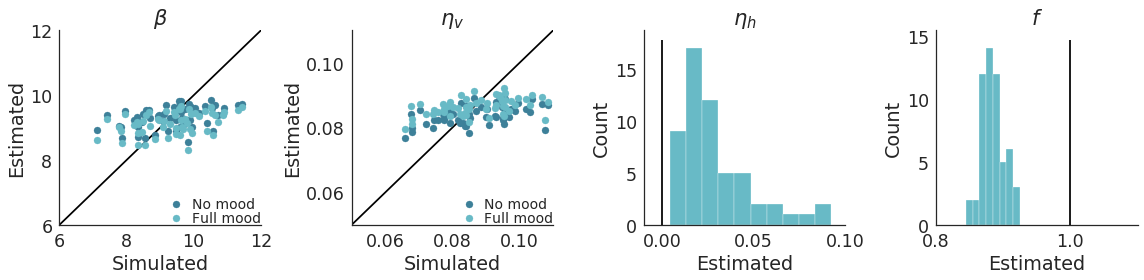

In [19]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,4,figsize=(16,4))

## Plot beta / eta_v.
for ax, simulated, param, lim, title in zip(axes[:2], [beta, eta_v], ['beta','eta_v'], 
                                            [(6,12),(0.05,0.11)], [r'$\beta$', r'$\eta_v$']):
    
    ## Extract parameters.
    estimated = [np.median(load_fit(model)[param], axis=0) for model in models]

    ## Plot.
    for arr, color, label in zip(estimated, colors, labels): 
        ax.scatter(simulated, arr, color=color, label=label)
        
    ## Add info.
    ax.plot(lim, lim, color='k', zorder=0)
    ax.set(xlim=lim, xlabel='Simulated', ylim=lim, ylabel='Estimated', title=title)
    ax.legend(loc=4, borderpad=-0.5, labelspacing=0, handletextpad=0.1, fontsize=14)

## Plot eta_h / f.
for ax, simulated, param, lim, title in zip(axes[2:], [0, 1], ['eta_h','f'], 
                                            [(-0.01,0.1),(0.8,1.1)], [r'$\eta_h$', r'$f$']):
    
    ## Extract parameters.
    estimated = np.median(load_fit(model)[param], axis=0)
    
    ## Plot.
    sns.distplot(estimated, kde=False, color=color, hist_kws=dict(alpha=1, edgecolor='w'), ax=ax)
    
    ## Add info.
    ax.vlines(simulated, *ax.get_ylim(), color='k', zorder=10)
    ax.set(xlim=lim, xlabel='Estimated', ylabel='Count', title=title)

sns.despine()
plt.tight_layout()

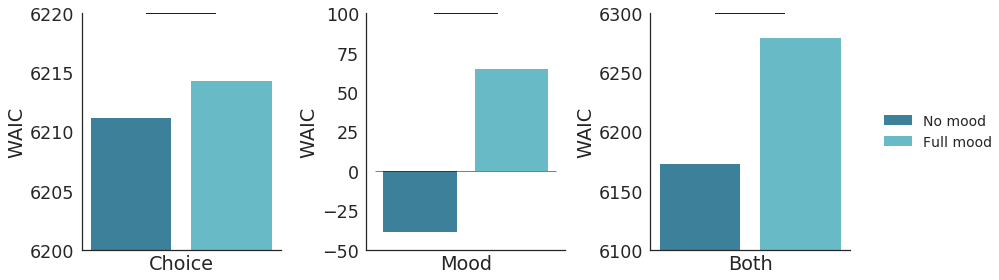

In [20]:
fig, axes = plt.subplots(1,3,figsize=(12,4))
xlabels = ['Choice', 'Mood', 'Both']
ylimits = np.array([(6200,6220), (-50,100), (6100,6300)])

for ax, var, xlabel, ylim in zip(axes, ['y','m','both'], xlabels, ylimits):
    
    for i in np.arange(1,len(models)):
        
        ## Perform model comparison.
        w1, w2, se = model_comparison(models[i-1], models[i], on=var, verbose=False)
        
        ## Plot.
        ax.bar([i-1,i],[w1,w2],color=colors[i-1:i+1])
        
        ## Add difference.
        if np.abs(w1 - w2) > se: ax.hlines(ylim[1], i-0.85, i-0.15 )
        
    if np.logical_xor(*ylim>0): ax.hlines(0,*ax.get_xlim(),lw=0.5)
    ax.set(xticks=[], xlabel=xlabel, ylim=ylim, ylabel='WAIC')
    
## Add legend.
for color, label in zip(colors, labels): ax.bar(0,0,color=color,label=label)
ax.legend(loc=7, bbox_to_anchor=(1.75,0.5), fontsize=14, borderpad=0)
    
sns.despine()
plt.tight_layout()

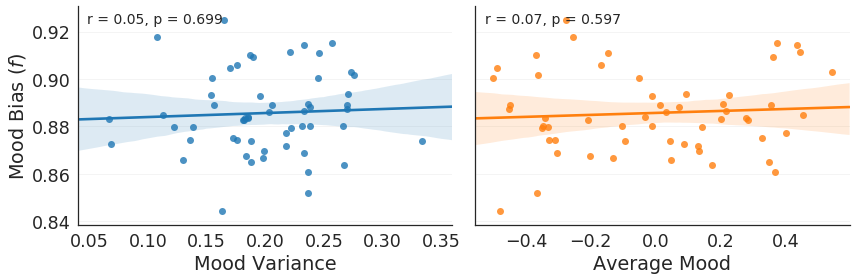

In [21]:
## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(12,4),sharey=True)

## Prepare data.
fit = load_fit('moodRL_centered_full_mood_glob_recovery')
fs = np.median(fit['f'], axis=0)

## Plot.
sns.regplot(Ms.std(axis=1), fs, ax=axes[0])
axes[0].grid(axis='y', alpha=0.2, zorder=0)
axes[0].set(xlabel='Mood Variance', ylabel=r'Mood Bias ($f$)')
axes[0].annotate('r = %0.2f, p = %0.3f' %(pearsonr(Ms.std(axis=1), fs)), xy=(0,0), 
                 xytext=(0.025, 0.925), xycoords='axes fraction', ha='left', fontsize=14)

sns.regplot(Ms.mean(axis=1), fs, ax=axes[1])
axes[1].grid(axis='y', alpha=0.2, zorder=0)
axes[1].set(xlabel='Average Mood')
axes[1].annotate('r = %0.2f, p = %0.3f' %(pearsonr(Ms.mean(axis=1), fs)), xy=(0,0), 
                 xytext=(0.025, 0.925), xycoords='axes fraction', ha='left', fontsize=14)

sns.despine()
plt.tight_layout()

Observed: t=6.58, p=0.000
Simulated: t=1.53, p=0.132


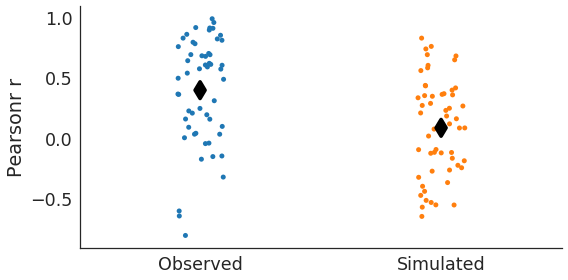

In [22]:
from pandas import concat

models = ['moodRL_centered_full_mood_glob', 'moodRL_centered_full_mood_glob_recovery']
labels = ['Observed', 'Simulated']

df = []
for model, label in zip(models, labels):
    
    ## Load StanFit.
    fit = load_fit(model)
    
    ## Prepare mood data.
    M = fit['M']
    h_pred = ( np.median(fit['h_pred'], axis=0).T + np.median(fit['beta_h'], axis=0) ).T
    Mhat = np.tanh(h_pred[...,[7,21,35]])
    
    ## Compute correlations.
    rvals = np.array([pearsonr(x.flatten(),y.flatten())[0] for x,y in zip(M,Mhat)])
    rvals = rvals[~np.isnan(rvals)]
    df.append(DataFrame(np.array([rvals, np.repeat(label,rvals.size)]).T,
              columns = ('R', 'Model')))
    
    ## Perform t-test.
    t, p = ttest_1samp(rvals, 0)
    print('%s: t=%0.2f, p=%0.3f' %(label,t,p))
    
df = concat(df)

df['R'] = df.R.astype(float)

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))
sns.stripplot('Model', 'R', data=df,  jitter=True, zorder=0, ax=ax)
sns.pointplot('Model', 'R', data=df, join=False, color='k', 
              ci=None, markers='d', scale=1.5, ax=ax)
ax.set(xlabel='', ylabel='Pearsonr r')

sns.despine()
plt.tight_layout()